In [7]:
import pandas as pd
import numpy as np
import nltk
import jieba #for tokenizing Chinese
import matplotlib.pyplot as plt
import collections
import random
import operator
import io
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import string
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm_notebook as tqdm
from wordcloud import WordCloud
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')   

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


(2500, 3)


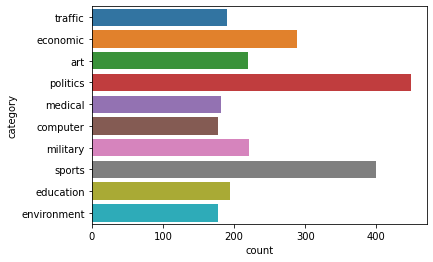

In [10]:
os.chdir('/content/drive/My Drive/movie review/CCTV-News-Analysis-master/bert')
df= pd.read_csv("train_data.csv")
print(df.shape)

sns.countplot(y='category', data=df);

Data Cleaning

In [11]:
#we only need the date and content for this particular analysis
subset = pd.DataFrame(df[[ 'text', 'category']].astype('str'))

def process_words(x):
    
        stop_words = [line.strip() for line in io.open('chinese_stop_words.txt', 'r', encoding='utf-8').readlines()]
        filtered = []
        
        seg = jieba.cut(x, cut_all=False) 
        
        for w in seg: 
            w= w.strip()
            if w not in stop_words and w not in string.punctuation and len(w)!=0: 
                filtered.append(w) 
        return filtered


subset['tokenized'] = subset['text'].apply(process_words)

EDA to see compare change in length of sentence in different categories

Distribution of text length by **category**

In [20]:
df1= df.copy()
df1['text_length']=df1['text'].str.len()
df1.groupby('category')['text_length'].describe().reset_index()

,category,count,mean,std,min,25%,50%,75%,max
0,art,220.0,2231.804545,2190.350314,228.0,615.00,1317.0,3084.50,10441.0
1,computer,178.0,4590.438202,7991.260778,214.0,1132.50,2191.5,4579.75,67029.0
2,economic,289.0,2478.328720,3527.132484,204.0,568.00,961.0,2577.00,21676.0
3,education,195.0,2284.456410,2291.466213,150.0,920.00,1671.0,2828.50,16218.0
4,environment,178.0,1567.707865,1927.226368,221.0,890.00,1178.5,1340.25,15197.0
5,medical,181.0,1114.270718,788.767329,250.0,543.00,994.0,1363.00,6883.0
6,military,221.0,1556.819005,2208.065137,205.0,435.00,718.0,1767.00,16999.0
7,politics,448.0,600.520089,399.837964,101.0,364.00,484.0,688.00,3212.0
8,sports,400.0,791.430000,611.008678,139.0,431.75,613.0,955.25,6458.0
9,traffic,190.0,1107.315789,1198.145894,187.0,454.00,711.0,1243.00,10645.0


Plot of median text length by **category**

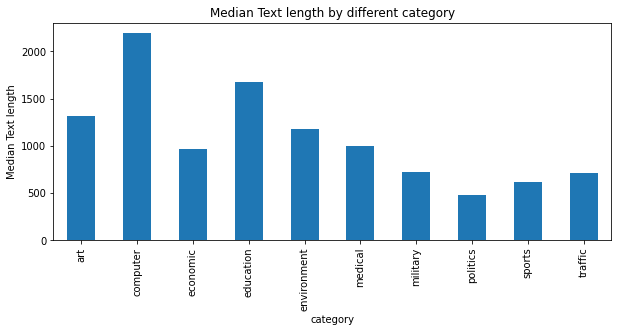

In [27]:
rcParams['figure.figsize'] = 10,4
df1.groupby('category')['text_length'].median().plot(kind='bar');
plt.ylabel("Median Text length"); 
plt.title("Median Text length by different category");

Histogram of  text length by **category**

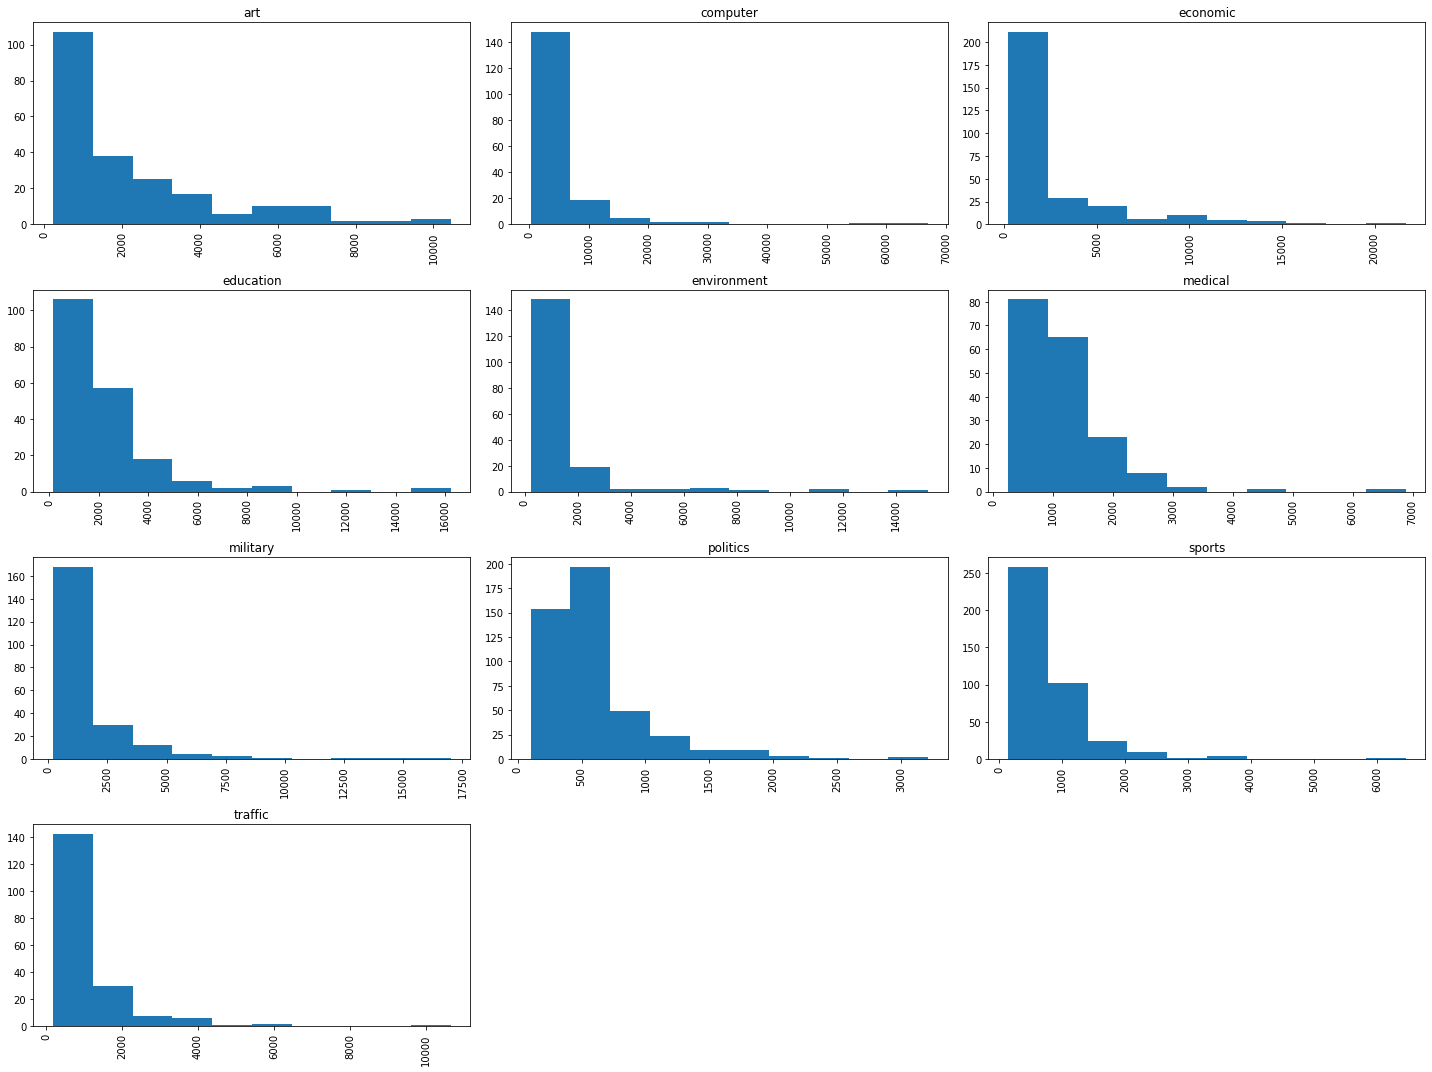

In [13]:
# the number of characters present in each title by labels
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
df['text'].str.len().hist(by=df['category']);

plt.tight_layout()

### Creation of vocabulary
- We will create vocabulary from our cleaned data. 
- Voculary will be in form of dictionary where key-value pair represent word and their frequency respectively
- We will remove the words which appreared less than 20 times

In [37]:
labeled_list = []

def label_articles(df, col, label):
    row = 0
    while row < len(df):
        #creates list of tuples with a label of being true or False About Xi
        labeled_list.append((df[col].iloc[row], df[label].iloc[row]))
        row += 1

#creates a list filled with labeled tuples
label_articles(subset,  'text', 'category')

sub_freqdist = [nltk.FreqDist(row) for row in subset['tokenized']]


#this function goes through the list of FreqDists, then adds up all the counts of each token
#it then returns another dictionary with the token and it's total count from all objects in the list
def create_summary(freqlist):
    entry_dict = {}
    i = 0
    while i < len(freqlist):        
        for t in freqlist[i].most_common():
            if t[0] not in entry_dict.keys():
                entry_dict[t[0]] = t[1]
            elif t[0] in entry_dict.keys():
                entry_dict[t[0]] += t[1]
        i += 1
    #trying to get the linebreak out of this:
    entry_dict['\n'] = 0
    return entry_dict
 
sub_freqdist = create_summary(sub_freqdist)

sorted_sub_freq = dict(sorted(sub_freqdist.items(), key=operator.itemgetter(1),reverse=True))
#change how many words you want to use as features by seeing how many times they're used throughout the dataset
sorted_sub_freq = {k:v for k, v in sorted_sub_freq.items() if v > 19}


print('Total words in vocabulary: ',len(sorted_sub_freq))
print(" Vocabulary (in sorted order): ")
str(sorted_sub_freq)[:100]

Total words in vocabulary:  5512
 Vocabulary (in sorted order): 


"{'中': 5265, '年': 4970, '月': 4157, '中国': 4053, '经济': 3503, '发展': 3128, '\\ufeff': 2500, '日': 2364, '说'"

### Using google translator to translate chinese words into english for visualisation purpose
- Create dictionary which will contain chinese to english word mapping

In [49]:
# !pip install googletrans
from googletrans import Translator #Google translator for chinese to english conversion

translator = Translator()

chinese_key = list(sorted_sub_freq.keys())
frequency= list(sorted_sub_freq.values())
english_key=[]

for key in chinese_key:
    result = translator.translate(key, dest='en', src='auto')
    english_key.append(result.text)

chinese_english_map= { chinese_key[i]: english_key[i] for i in range(len(chinese_key))}
str(chinese_english_map)[:100]

"{'中': 'in', '年': 'year', '月': 'month', '中国': 'China', '经济': 'economic', '发展': 'development of', '\\uf"

In [50]:
# Create dataframe which will word and its frequency (for all documents)
res = dict(zip(english_key, frequency))
df_word =pd.DataFrame(res,index=[0]).T.reset_index()
df_word.columns=['word','count']
df_word.sort_values(by='count',ascending=False,inplace=True)
df_word.head()

,word,count
3,China,4053
4,economic,3503
5,development of,3128
6,﻿,2500
8,Say,2329


Create barplot showing frequency of top 50 words (all documents) 

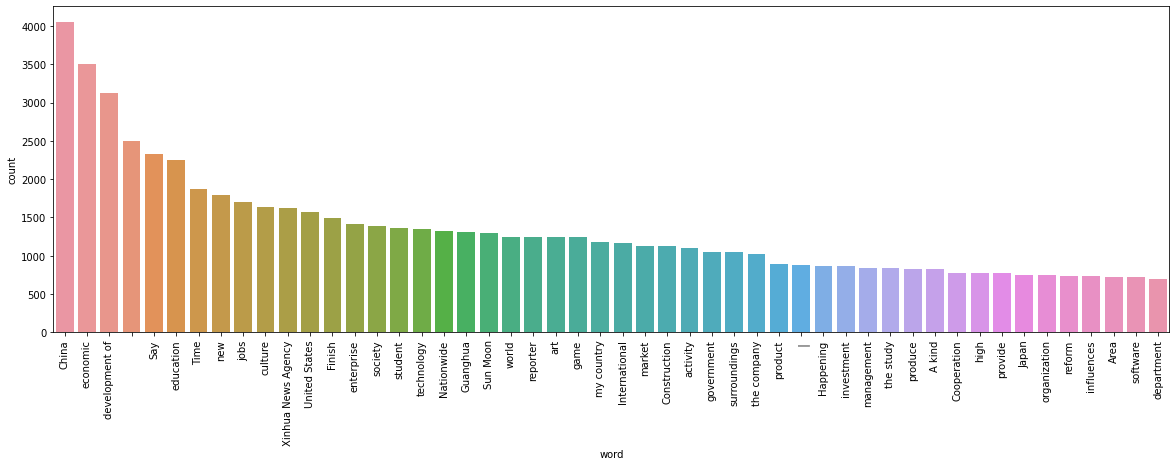

In [42]:
plt.figure(figsize=(20,6))
sns.barplot(x='word',y='count',data=df_word.head(50))
plt.xticks(rotation=90);

Create a function which will generate wordcloud for different category

In [40]:
def generate_word_cloud(labels):
  sub_freqdist = [nltk.FreqDist(row) for row in subset[subset.category==labels]['tokenized']]

  #this function goes through the list of FreqDists, then adds up all the counts of each token
  #it then returns another dictionary with the token and it's total count from all objects in the list
  def create_summary(freqlist):
      entry_dict = {}
      i = 0
      while i < len(freqlist):        
          for t in freqlist[i].most_common():
              if t[0] not in entry_dict.keys():
                  entry_dict[t[0]] = t[1]
              elif t[0] in entry_dict.keys():
                  entry_dict[t[0]] += t[1]
          i += 1
      #sort of cheating to get the linebreak out of this:
      entry_dict['\n'] = 0
      return entry_dict
  
  sub_freqdist = create_summary(sub_freqdist)

  sorted_sub_freq = dict(sorted(sub_freqdist.items(), key=operator.itemgetter(1),reverse=True))
  #change how many words you want to use as features by seeing how many times they're used throughout the dataset
  sorted_sub_freq = {k:v for k, v in sorted_sub_freq.items() if v > 19}

  new_key= [chinese_english_map[i] for i in sorted_sub_freq.keys() ]
  sorted_sub_freq_eng = dict(zip(new_key,sorted_sub_freq.values()))
  
  wordcloud = WordCloud(width=3000,height=2500,background_color='white',).generate_from_frequencies(sorted_sub_freq_eng)
  plt.figure(figsize=(10, 10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

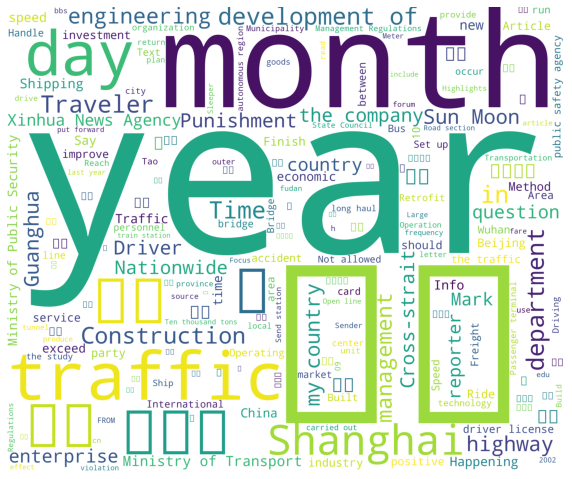

In [98]:
generate_word_cloud('traffic')

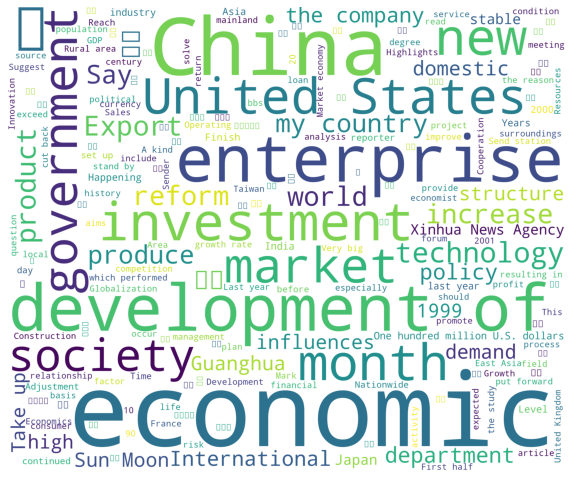

In [99]:
generate_word_cloud('economic')

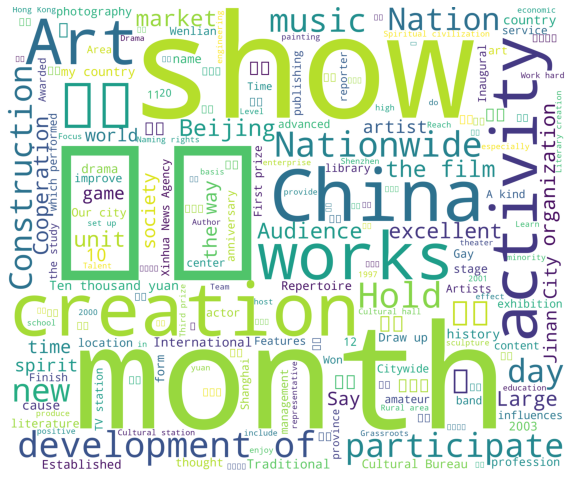

In [100]:
generate_word_cloud('art')

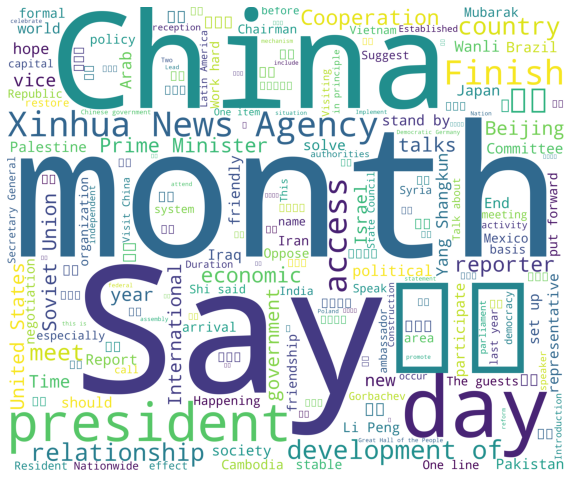

In [101]:
generate_word_cloud('politics')

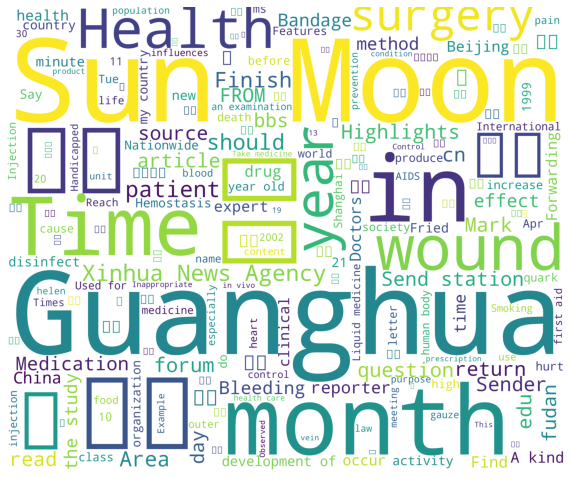

In [102]:
generate_word_cloud('medical')

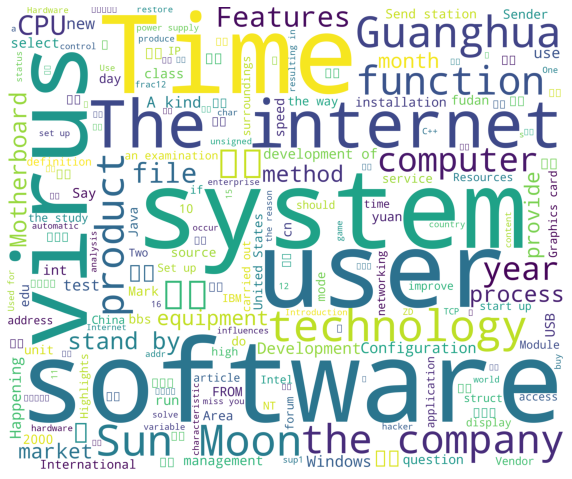

In [103]:
generate_word_cloud('computer')

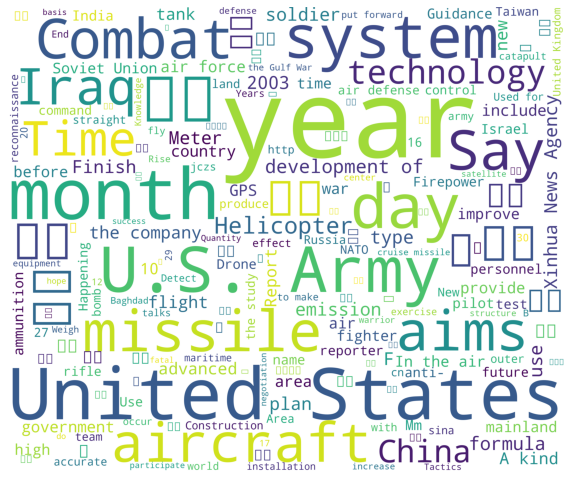

In [104]:
generate_word_cloud('military')

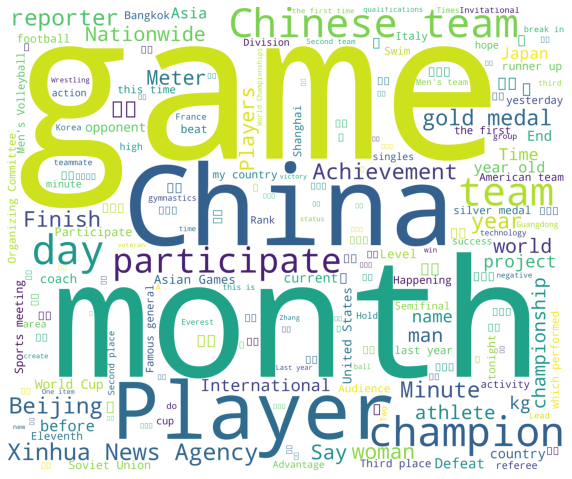

In [105]:
generate_word_cloud('sports')

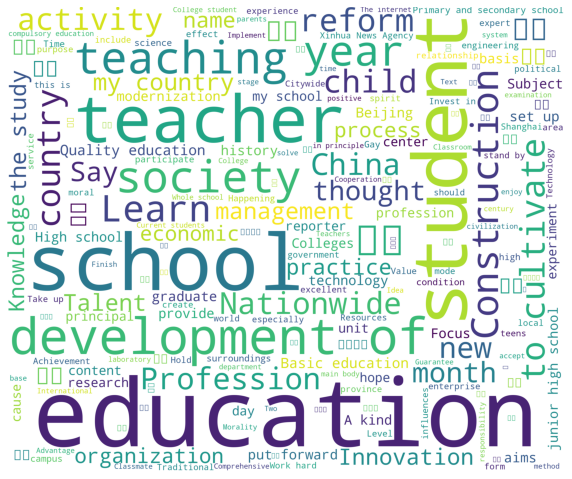

In [106]:
generate_word_cloud('education')

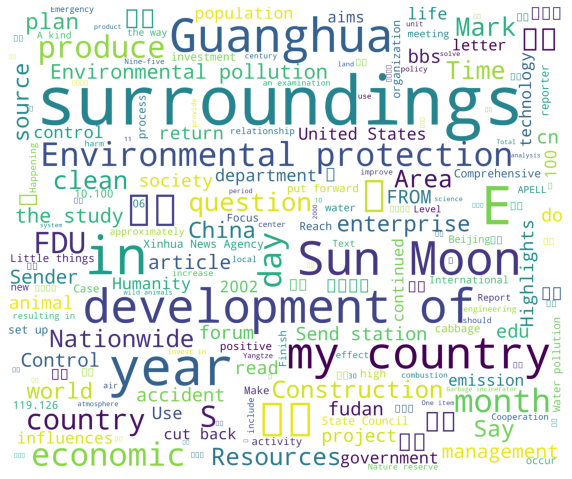

In [107]:
generate_word_cloud('environment')


Creates a dictionary with all words and whether or not they appear in an article

In [55]:
len(sorted_sub_freq)

5512

### We have total 5512 significant words(features) in our model.
- For each row(article), we will create a dictionary which will tell us whether or not that words have appreared in an article

In [54]:
feature_list = list(sorted_sub_freq.keys())

def get_features(labeled_list):
    tokenized = process_words(labeled_list)
    features = {}
    for char_set in feature_list:
        features[char_set] = (char_set in tokenized)
    return features

# #creates a dictionary with all words and whether or not they appear in an article
feature_sets = [(get_features(art), label) for (art, label) in labeled_list]

In [71]:
# For illustration Purpose
# For 5th row which belong to art category, we will check for all 5512 words whether they have appreared or not
print('No of words: ', len(feature_sets[5][0]))
print('First 100 words in dictionary: ',str(feature_sets[5])[:100])
print('Category: ',feature_sets[5][1])

No of words:  5512
First 100 words in dictionary:  ({'中': True, '年': True, '月': True, '中国': True, '经济': True, '发展': True, '\ufeff': True, '日': False, '
Category:  art


#### Deviding into train-test data in (90:10) ratio
- Data is in form of dictionary which contains labels at end

In [72]:
random.seed(42)
random.shuffle(feature_sets)
print(len(feature_sets))

train_set = feature_sets[:2000] #Dictionary with labels
test_set = feature_sets[2000:]

2500


Logistic Regression

In [74]:
Log_classif = SklearnClassifier(LogisticRegression(C=1000))

Log_classif.train(train_set)
print(Log_classif.labels())
print("Train Accuracy: ",nltk.classify.accuracy(Log_classif, train_set))
print("Test Accuracy: ",nltk.classify.accuracy(Log_classif, test_set))

['art', 'computer', 'economic', 'education', 'environment', 'medical', 'military', 'politics', 'sports', 'traffic']
Train Accuracy:  0.9995
Test Accuracy:  0.926


Naive Bayes

In [73]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print("Train Accuracy: ",nltk.classify.accuracy(classifier, test_set))
print("Test Accuracy: ",nltk.classify.accuracy(classifier, train_set))

Train Accuracy:  0.792
Test Accuracy:  0.827


Support Vector Machine

In [75]:
SVC_classif = SklearnClassifier(SVC(), sparse=True)

SVC_classif.train(train_set)
print(SVC_classif.labels())
print("Train Accuracy: ",nltk.classify.accuracy(SVC_classif, train_set))
print("Test Accuracy: ",nltk.classify.accuracy(SVC_classif, test_set))

['art', 'computer', 'economic', 'education', 'environment', 'medical', 'military', 'politics', 'sports', 'traffic']
Train Accuracy:  0.972
Test Accuracy:  0.87
